In [45]:
import matplotlib.pyplot as plt

import spacy

import random
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

In [46]:
MODEL_STORE_PATH = "NLP/NMT/Seq2Seq/Seq2Seq"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


In [44]:
SEED = 1729

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
def elapsed_time(start_time, end_time):
    time_taken = end_time - start_time
    elapsed_min = int(time_taken / 60)
    elapsed_sec = int(time_taken - (elapsed_min * 60))
    
    return elapsed_min, elapsed_sec

# Data Preprocessing

In [ ]:
!python -m spacy download de
!python -m spacy download en

In [8]:
de_model = spacy.load('de')
en_model = spacy.load('en')

In [9]:
def tokenize_en(sentence):
    tokens = []
    for token in de_model.tokenizer(sentence):
        tokens.append(token.text.lower())
    
    return tokens

def tokenize_de(sentence):
    tokens = []
    for token in en_model.tokenizer(sentence):
        tokens.append(token.text.lower())
    
    return tokens

In [10]:
print(tokenize_de("Hallo, wie geht's Ihnen?"))
print(tokenize_en("Hello, how are you?"))

['hallo', ',', 'wie', 'geht', "'s", 'ihnen', '?']
['hello', ',', 'how', 'are', 'you', '?']


In [11]:
SOURCE_Field = Field(eos_token = '<eos>', init_token = '<sos>', lower = True, tokenize = tokenize_de)
TARGET_Field = Field(eos_token = '<eos>', init_token = '<sos>', lower = True, tokenize = tokenize_en)

In [12]:
start_time = time.time()
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SOURCE_Field, TARGET_Field))
end_time = time.time()

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 866kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 166kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 158kB/s]


In [13]:
print("Time taken to generate train, valid and test datasets:",elapsed_time(start_time, end_time))

Time taken to generate train, valid and test datasets: (0, 9)


In [14]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [15]:
SOURCE_Field.build_vocab(train_data, min_freq = 2)
TARGET_Field.build_vocab(train_data, min_freq = 2)

In [16]:
print(f"Vocabulary Size of Source Language: {len(SOURCE_Field.vocab)}")
print(f"Vocabulary Size of Target Language: {len(TARGET_Field.vocab)}")

Vocabulary Size of Source Language: 7873
Vocabulary Size of Target Language: 5923


# Neural Network

### Encoder

* The encoder is the first stage of Seq2Seq, and is a unidirectional two-layer RNN. (`num_layers = 2`)
* The input given to it is the sequence of words (in the source language). [`input`] = `[time_steps, batch_size]`
* The sequence needs to be converted to dense vectors to get their word representations. This is the actual input given (and the initial hidden state of RNN) to the RNN. (`embedded = self.dropout(self.embedding(input))`)  

    `[embedded]` = `[time_steps, batch_size, embedding_dim]`
    
    
* These embedded vectors are then passed inside the RNN, to get the output, and the final hidden state after going through each timestep ie. after it has gone through the whole sequence. (`output_rnn, states = self.rnn(embedded)`)

    `[output_rnn] = [time_steps, batch_size, num_directions*hidden_dim]`

    `[states] = (hidden, cell) = [num_layers*num_directions, batch_size, hidden_dim]`

     Here `num_directions` is 1

* This output will be used by the Decoder in the next stage

In [17]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, enc_dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = num_layers, dropout = enc_dropout)
        self.dropout = nn.Dropout(enc_dropout)

    def forward(self, input):
        # [input] = [time_steps, batch_size]
        embedded = self.dropout(self.embedding(input))                          # [embedded] = [time_steps, batch_size, embedding_dim]
        output_rnn, states = self.rnn(embedded)                                 # [output_rnn] = [time_steps, batch_size, num_directions*hidden_dim]   Here, number of directions is 1
                                                                                # [states] = (hidden, cell) = [num_layers*num_directions, batch_size, hidden_dim]
        return states


### Decoder

* The Decoder is the second stage of Seq2Seq, and it also a unidirectional two-layer RNN. (`num_layers = 2`)
* The input given to it is a word (in the target language) -  [`input`] = `[time_steps = 1, batch_size]` (and the initial hidden state of RNN)
* The initial hidden state of the RNN will be the output hidden state of the Encoder RNN. ie. the context vector that is produced after it went through the sequence in the source language.
* The word needs to be converted to a dense vector to get its word representation. This is the actual input given to the Decoder RNN. `[embedded]` = `[time_steps = 1, batch_size, embedding_dim]`
    
    `embedded = self.dropout(self.embedding(input))`  
* These embedded vectors (along with the hidden state) of those timesteps are then passed inside the RNN, to get the output and the hidden state of the next cell. (`output_rnn, states = self.rnn(embedded)`)

    `[output_rnn] = [time_steps, batch_size, num_directions*hidden_dim]`

    `[states] = (hidden, cell) = [num_layers*num_directions, batch_size, hidden_dim]`

     Here number of directions is 1
* However this output needs to be passed into a Linear layer first to get the actual predicted word. (`output = self.fc(output).unsqueeze(0)`)

    `[output]` = `[time_steps, batch_size, vocab_size]`

In [18]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dec_dropout):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = num_layers, dropout = dec_dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dec_dropout)

    def forward(self, input, states):
        # input = [1, batch_size]
        embedded = self.dropout(self.embedding(input))                          # [embedded] = [time_steps = 1, batch_size, embedding_dim]
        output_rnn, states = self.rnn(embedded, states)                         # [output_rnn] = [time_steps = 1, batch_size, num_directions*hidden_dim]   Here, number of directions is 1
        output = self.fc(output_rnn).unsqueeze(0)                               # [output] = [time_steps = 1, batch_size, vocab_size]

        return output, states

## Seq2Seq

We now combine Encoder and Decoder to create the Seq2Seq model.

    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

* As mentioned earlier, the encoder is the first component of the Seq2Seq model. Hence, the input to the Encoder is actually the input given to the Seq2Seq model: (`enc_input = input`)

    `[enc_input] = [time_steps, batch_size]`

* We obtain the output of the Encoder by passing this `enc_input` through the Encoder. (`enc_states = self.encoder(enc_input)`), which is the final hidden state after going through the whole sequence in the source language.
* These output hidden states of the encoder will be the initial hidden state of the decoder. It is the context vector of the whole sequence in source language. (`dec_states = enc_states`)

**Note:** The target vector (`target`) is the entire sequence in the target language. However, unlike in the encoder, we simply *can not* pass in the whole sequence all at once into the decoder. This is simply because we do not know the output sequence yet - this is what we have to predict! 

* Hence, we need to pass in the first word (and the initial hidden state ie. `dec_states`) into the decoder, get the output and hidden states, and then pass these again again to compute the output and hidden state of the next timestep. This is done until we reach the end of the sequence ie. until `time_steps`
      dec_input = target[0].unsqueeze(0) 
      for t in range(1, time_steps):
          output, dec_states = self.decoder(dec_input, dec_states) 
          output = output.squeeze()                        
          predictions[t] = output.view(batch_size, self.decoder.output_dim)
          if random.random() < teacher_forcing_ratio:
              dec_input = target[t].unsqueeze(0)
          else:
              dec_input = output.argmax(1).unsqueeze(0)

* **Teacher forcing ratio** is the use of the expected output instead of the actual output at a time step as the input for the next time step. ie. if `teacher_forcing_ratio` is 0.75, then the expected output is used as input 75% of the time.

* Finally, we return the predictions, which is the predicted sequence in the target language. Note that we have returned `predictions[1:]` and not `predictions`. This because the first word in `predictions` is `<sos>` (start-of-sequence token).

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input, target, teacher_forcing_ratio):
        enc_input = input                                                                         # [enc_input] = [time_steps, batch_size]
        enc_states = self.encoder(enc_input)
        dec_states = enc_states
        # [target] = [time_steps, batch_size]                                                 
        time_steps = target.shape[0]
        batch_size = target.shape[1]
        predictions = torch.zeros(time_steps, batch_size, self.decoder.output_dim).to(device)     # [predictions] = [time_steps, batch_size, output_dim]
        dec_input = target[0].unsqueeze(0)                                                        # [dec_input] = [1, batch_size] - First time_step is given as input
        for t in range(1, time_steps):
            output, dec_states = self.decoder(dec_input, dec_states) 
            output = output.squeeze()                        
            predictions[t] = output.view(batch_size, self.decoder.output_dim)
            if random.random() < teacher_forcing_ratio:
                dec_input = target[t].unsqueeze(0)
            else:
                dec_input = output.argmax(1).unsqueeze(0)

        return predictions[1:]

In [20]:
def epoch_train(train_iterator, model, criterion, optimizer, clip=1):
    model.train()
    epoch_loss = 0
    for batch in train_iterator:
        model.zero_grad()
        batch_source = batch.src
        batch_target = batch.trg
        batch_outputs = model(batch_source, batch_target, teacher_forcing_ratio=0.5)
        batch_outputs = batch_outputs.view(-1, batch_outputs.shape[-1])
        batch_targets = batch_target[1:].view(-1)
        batch_loss = criterion(batch_outputs, batch_targets.to(device))
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += batch_loss.item()

    return epoch_loss/len(train_iterator)

In [21]:
def epoch_test(test_iterator, model, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch in test_iterator:
            model.zero_grad()
            batch_source = batch.src
            batch_target = batch.trg
            batch_outputs = model(batch_source, batch_target, 0)
            batch_outputs = batch_outputs.view(-1, batch_outputs.shape[-1])
            batch_targets = batch_target[1:].view(-1)
            batch_loss = criterion(batch_outputs, batch_targets.to(device))
            eval_loss += batch_loss.item()
        
        return eval_loss/len(test_iterator)

# Hyperparameters

In [22]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)

In [23]:
CLIP = 1
NUM_EPOCHS = 20
LR = 1e-3
HIDDEN_DIM = 512
SRC_VOCAB_SIZE = len(SOURCE_Field.vocab)
TRG_VOCAB_SIZE = len(TARGET_Field.vocab)
EMBEDDING_DIM = 256
NUM_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

PRINT_EVERY = 1

In [24]:
target_padding_index = TARGET_Field.vocab.stoi[TARGET_Field.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = target_padding_index)

In [25]:
encoder = Encoder(SRC_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, ENC_DROPOUT).to(device)
decoder = Decoder(TRG_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DEC_DROPOUT).to(device)
seq2seq = Seq2Seq(encoder, decoder).to(device)
optimizer = optim.AdamW(seq2seq.parameters(), LR)

In [26]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [27]:
seq2seq.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7873, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5923, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=512, out_features=5923, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters.')

The model has 13,926,691 trainable parameters.


# Training

In [30]:
print(f"Learning Rate: {LR}, Hidden Dimensions: {HIDDEN_DIM}",end="\n\n")
train_losses = []
valid_losses = []
start_time = time.time()
print("Training started",end="\n\n")

for epoch in range(1, NUM_EPOCHS + 1):

    train_loss = epoch_train(train_iterator, seq2seq, criterion, optimizer, CLIP)
    train_losses.append(train_loss)
    valid_loss = epoch_test(test_iterator, seq2seq, criterion)
    valid_losses.append(valid_loss)

    if epoch % PRINT_EVERY == 0:
        end_time = time.time()
        elapsed_min, elapsed_sec = elapsed_time(start_time, end_time)
        print(f"Epoch {epoch} | Time taken since start of training: {elapsed_min}min {elapsed_sec}sec")
        print(f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
        print(f"Training PPL: {math.exp(train_loss):.4f} | Validation PPL: {math.exp(valid_loss):.4f}")
        print("")

print("Training finished", end="\n\n")
elapsed_min, elapsed_sec = elapsed_time(start_time, end_time)
print(f"Total time taken for training: {elapsed_min}min {elapsed_sec}sec")
elapsed_min, elapsed_sec = elapsed_time(start_time/NUM_EPOCHS, end_time/NUM_EPOCHS)
print(f"Average time taken per epoch: {elapsed_min}min {elapsed_sec}sec")

Learning Rate: 0.001, Hidden Dimensions: 512

Training started

Epoch 1 | Time taken since start of training: 0min 34sec
Training Loss: 5.0368 | Validation Loss: 5.0542
Training PPL: 153.9705 | Validation PPL: 156.6861

Epoch 2 | Time taken since start of training: 1min 10sec
Training Loss: 4.4383 | Validation Loss: 4.6751
Training PPL: 84.6349 | Validation PPL: 107.2385

Epoch 3 | Time taken since start of training: 1min 46sec
Training Loss: 4.1070 | Validation Loss: 4.4943
Training PPL: 60.7646 | Validation PPL: 89.5088

Epoch 4 | Time taken since start of training: 2min 21sec
Training Loss: 3.8802 | Validation Loss: 4.3706
Training PPL: 48.4345 | Validation PPL: 79.0939

Epoch 5 | Time taken since start of training: 2min 57sec
Training Loss: 3.7327 | Validation Loss: 4.2455
Training PPL: 41.7922 | Validation PPL: 69.7912

Epoch 6 | Time taken since start of training: 3min 32sec
Training Loss: 3.5700 | Validation Loss: 4.1160
Training PPL: 35.5178 | Validation PPL: 61.3135

Epoch 7 |

In [31]:
torch.save(seq2seq.state_dict(), MODEL_STORE_PATH + ".pth")

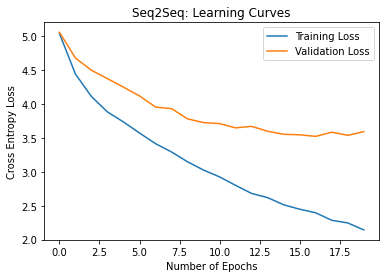

<Figure size 432x288 with 0 Axes>

In [32]:
plt.title("Seq2Seq: Learning Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label= "Validation Loss")
plt.legend()
plt.show()
plt.savefig(MODEL_STORE_PATH + ".jpeg")


# Testing

In [33]:
seq2seq.load_state_dict(torch.load(MODEL_STORE_PATH + ".pth"))

<All keys matched successfully>

In [34]:
seq2seq.eval()
test_loss = epoch_test(test_iterator, seq2seq, criterion)
print(f"Test Loss: {test_loss:.4f} | Test PPL: {math.exp(test_loss):.4f}")


Test Loss: 3.5904 | Test PPL: 36.2474


In [35]:
def getInputTensor(sentence, src_field):
    tokens = [src_field.init_token] + [token for token in sentence] + [src_field.eos_token]
    seq_len = len(tokens)
    input_tensor = torch.LongTensor([src_field.vocab.stoi[token] for token in tokens]).to(device)
    return input_tensor.view(seq_len, 1)

In [38]:
def Translate(src_sentence, src_field, trg_field, model):
    input_tensor = getInputTensor(src_sentence, src_field)
    max_len = 4*input_tensor.shape[0]

    with torch.no_grad():
        enc_states = model.encoder(input_tensor)
    dec_states = enc_states
    sos_id = trg_field.vocab.stoi[trg_field.init_token]
    eos_id = trg_field.vocab.stoi[trg_field.eos_token]
    predicts = [sos_id]
    len = 1
    while len < max_len:
        input = torch.LongTensor([predicts[-1]]).view((1, 1)).to(device)
        with torch.no_grad():
            output, dec_states = model.decoder(input, dec_states)
        output = output.squeeze()
        output = output.view(-1, model.decoder.output_dim)
        predicts.append(output.argmax(-1).item())
        len += 1
        if predicts[-1] == eos_id:
            break
    sentence = [trg_field.vocab.itos[id] for id in predicts[1:]]
    return sentence

In [41]:
idx = int(random.random() * len(test_data.examples))
example = test_data.examples[idx]
src_sentence = example.src
trg_sentence = example.trg
print("German Sentence: ", ' '.join(src_sentence))
translation = Translate(src_sentence, SOURCE_Field, TARGET_Field, seq2seq)
print("Predicted Translation: ", ' '.join(translation[:-1]))
print("Actual Translation: ", ' '.join(trg_sentence))

German Sentence:  ein kleines mädchen schiebt seinen roller über eine wiese mit bäumen .
Predicted Translation:  a little girl is riding a tricycle in a field of grass .
Actual Translation:  a little girl is pushing her scooter through a grassy tree lined field .


# BLEU Score

In [42]:
def Calculate_BLEU(data, src_field, trg_field, model):
    trgs = []
    predicted_trgs = []
    for i in range(len(data.examples)):
        src_sentence = vars(data[i])['src']
        trg_sentence = vars(data[i])['trg']
        try:                                # Sometimes(rarely) CUDA throws a "Device side assert triggered" error. So, just to avoid restarting runtime.
            predicted_trg = Translate(src_sentence, src_field, trg_field, model)
            predicted_trgs.append(predicted_trg[:-1])
            trgs.append([trg_sentence])
        except:
            pass
    return bleu_score(predicted_trgs, trgs)

In [43]:
bleu_score_test = Calculate_BLEU(test_data, SOURCE_Field, TARGET_Field, seq2seq)
print(f"BLEU score on Testing Data: {bleu_score_test*100:.2f}")

BLEU score on Testing Data: 20.59
